### Check GPU

In [39]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import PIL.Image
import matplotlib.pyplot as plt

from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from tqdm.notebook import tqdm


In [40]:
from tensorboard import version; print(version.VERSION)

2.4.1


In [41]:
# check GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset and dataloader

In [42]:
PATH = '/content/drive/MyDrive/' 

- resize all the images to a size of 32x32
- convert them to single-channel images

Dataset.getitem() should return:
- two 32x32, single-channel images
- one target label

In [43]:
class ImageDataset(Dataset):
    def __init__(self, info_file, index_file, image_dir, transform=None):
        self.info_df = pd.read_csv(info_file)  
        self.index_df = pd.read_csv(index_file, sep=',',header =None,names=['index','source'])
        #self.classes = np.array(self.info_df.columns[1:]) # image labels 
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, idx):
        img_index1 = self.info_df.iloc[idx, 0]
        img_name1 = os.path.join(self.image_dir, str(self.index_df.iloc[img_index1-1, 1])[5:])
        image1 = PIL.Image.open(img_name1)
        image1 = image1.convert('L')
        
        img_index2 = self.info_df.iloc[idx, 1]
        img_name2 = os.path.join(self.image_dir, str(self.index_df.iloc[img_index2-1, 1])[5:])
        image2 = PIL.Image.open(img_name2)
        image2 = image2.convert('L')
        
        label = self.info_df.iloc[idx, 2]
        
        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        
        return image1, image2, label

    def __len__(self):
        return len(self.info_df)

Check dataset

In [44]:
# more transform functions can refer to https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),    # range [0, 255]  -> [0.0,1.0] Convert a PIL Image or numpy.ndarray (H x W x C)  to tensor (C x H x W) 
     transforms.Normalize((0.5,), (0.5,))   # channel=（channel-mean）/std  -> [-1, 1]
     ])

# if the image has one channel (grayscale), normalise operation will be 
#transforms.Normalize((0.5, ), (0.5, ))

In [45]:
dataset = ImageDataset(PATH + 'train.csv', PATH + 'index.txt',PATH, transform=transform)

Load image dataset

In [46]:
train_set = ImageDataset(PATH + 'train.csv', PATH + 'index.txt', PATH, transform=transform)
valid_set = ImageDataset(PATH + 'valid.csv', PATH + 'index.txt', PATH, transform=transform)
test_set = ImageDataset(PATH + 'test.csv', PATH + 'index.txt', PATH, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128,shuffle=False)


### Define Convolutional Neural Network

In [47]:
class SiameseNetwork(nn.Module):
    def __init__(self, aggregation_type):
        super(SiameseNetwork, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding = 1), 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 1),  
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.AvgPool2d(kernel_size=16,stride=1),
            
            nn.Flatten(),
            
        )
        self.aggregation_type = aggregation_type
        if(self.aggregation_type=="concatenation"):
            self.fc1 = nn.Linear(1024,512) # concatenation
        elif(self.aggregation_type=="absolute_substraction"):
            self.fc1 = nn.Linear(512,512) # absolute substraction
        self.drop_out = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512,1)

    def forward(self, image1, image2):
        
        image1 = self.cnn(image1)
        image2 = self.cnn(image2)
        
        if(self.aggregation_type=="concatenation"):
            h3 = torch.cat((image1,image2),1) #concatenation
        elif(self.aggregation_type=="absolute_substraction"):
            h3 = torch.abs(torch.sub(image1, image2)) #absolute substraction

        output = F.relu(self.fc1(h3))
        output = self.drop_out(output)
        output = self.fc2(output)
        output = nn.Sigmoid()(output)
        #output = torch.reshape(output,(-1,))
        
        return output

#### Function count the total number of trainable parameters

When aggregation function is absolute difference

In [48]:
net_absolute_substraction = SiameseNetwork("absolute_substraction").cuda()
summary(net_absolute_substraction, [(1, 32, 32),(1, 32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

When aggregation function is concatenation

In [49]:
net_concatenation = SiameseNetwork("concatenation").cuda()
summary(net_concatenation, [(1, 32, 32),(1,32,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

### 4.2.3 Training and Validation

In [50]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path #f'cifar_net.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from {save_path}, with val loss: {val_loss}')
    return val_loss

def TRAIN(net, train_loader, valid_loader,  num_epochs, criterion, optimizer, val_loss,threshold, device, save_name):
    
    step_list = []
    training_loss_list = []
    valid_loss_list = []
    
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
        print('Resume training')


    no_step = 0;
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        running_corrects = 0
        for input1,input2, labels in tqdm(train_loader):
            
            no_step +=1
            input1 = input1.to(device)
            input2 = input2.to(device)
            labels = labels.to(device)
            
            labels = labels.unsqueeze(1)
            labels = labels.float()

            '''Training of the model'''
            # Forward pass
            outputs = net(input1, input2)
            
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss = loss.item()
            running_loss += loss.item()
            preds = torch.gt(outputs, threshold).int()                       
            running_corrects += torch.sum(preds == labels.data)            
            
            with torch.no_grad():
                net.eval()
                running_loss_valid = 0.0
                running_corrects_valid = 0
                for input1_valid,input2_valid, labels_valid in tqdm(valid_loader):
            
                    input1_valid = input1_valid.to(device)
                    input2_valid = input2_valid.to(device)
                    labels_valid = labels_valid.to(device)

                    labels_valid = labels_valid.unsqueeze(1)
                    labels_valid = labels_valid.float()

                    outputs_valid = net(input1_valid,input2_valid)
                    loss_valid = criterion(outputs_valid, labels_valid)

                    running_loss_valid += loss_valid.item()
                    preds_valid = torch.gt(outputs_valid, threshold).int()
                    running_corrects_valid += torch.sum(preds_valid == labels_valid.data)

                valid_loss = running_loss_valid / len(valid_loader)
                valid_acc = running_corrects_valid / float(len(valid_loader.dataset))
            
            if(no_step%10==0):
                step_list.append(no_step)
                training_loss_list.append(training_loss)
                valid_loss_list.append(valid_loss)
                
                print("step ",no_step," training loss: ",training_loss,", validation loss: ",valid_loss,"\n")
            

        train_loss = running_loss / len(train_loader)
        train_acc = running_corrects / float(len(train_loader.dataset))

        with torch.no_grad():
            net.eval()
            running_loss = 0.0
            running_corrects = 0
            for input1,input2, labels in tqdm(valid_loader):
            
                input1 = input1.to(device)
                input2 = input2.to(device)
                labels = labels.to(device)
                
                labels = labels.unsqueeze(1)
                labels = labels.float()

                outputs = net(input1,input2)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                preds = torch.gt(outputs, threshold).int()
                running_corrects += torch.sum(preds == labels.data)

            valid_loss = running_loss / len(valid_loader)
            valid_acc = running_corrects / float(len(valid_loader.dataset))

        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            save_checkpoint(save_name, net, optimizer, best_val_loss)
    
    plt.plot(step_list,training_loss_list,label="Training Loss")
    plt.plot(step_list,valid_loss_list,label="Validation Loss")
    plt.xlabel('Number of steps')
    # Set a title of the current axes.
    plt.title('Traning and Validation loss curves')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()
    
    print('Finished Training')

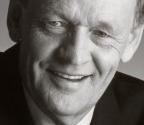

In [51]:
from IPython.display import Image
Image('/content/drive/MyDrive/Images/213/frontal/01.jpg')


step  10  training loss:  0.6938127279281616 , validation loss:  0.6936847766240438 




step  20  training loss:  0.6937133073806763 , validation loss:  0.6936866541703542 




step  30  training loss:  0.6935640573501587 , validation loss:  0.6937313675880432 




Epoch [1/20], Train Loss: 0.6932, Train Acc: 0.5002, Valid Loss: 0.6937,  Valid Acc: 0.5000
Model saved to cifar_net.pt



step  40  training loss:  0.6935616731643677 , validation loss:  0.69368248184522 




step  50  training loss:  0.6938287019729614 , validation loss:  0.6936292548974355 




step  60  training loss:  0.6932330131530762 , validation loss:  0.6935616135597229 




step  70  training loss:  0.6934753656387329 , validation loss:  0.6935149629910787 




Epoch [2/20], Train Loss: 0.6932, Train Acc: 0.5008, Valid Loss: 0.6935,  Valid Acc: 0.5000
Model saved to cifar_net.pt



step  80  training loss:  0.6932082772254944 , validation loss:  0.693515956401825 




step  90  training loss:  0.6932656764984131 , validation loss:  0.6934991379578909 




step  100  training loss:  0.6926687955856323 , validation loss:  0.69347416361173 




step  110  training loss:  0.6927575469017029 , validation loss:  0.6934632261594137 




Epoch [3/20], Train Loss: 0.6932, Train Acc: 0.4996, Valid Loss: 0.6935,  Valid Acc: 0.5000
Model saved to cifar_net.pt



step  120  training loss:  0.6928120851516724 , validation loss:  0.6934475600719452 




step  130  training loss:  0.6930423974990845 , validation loss:  0.6934091846148173 




step  140  training loss:  0.6929385662078857 , validation loss:  0.6933987438678741 




step  150  training loss:  0.6933443546295166 , validation loss:  0.6934208571910858 




Epoch [4/20], Train Loss: 0.6931, Train Acc: 0.5004, Valid Loss: 0.6934,  Valid Acc: 0.5000
Model saved to cifar_net.pt



step  160  training loss:  0.6936303377151489 , validation loss:  0.6933880050977071 




step  170  training loss:  0.6931931972503662 , validation loss:  0.6933463911215464 




step  180  training loss:  0.692970871925354 , validation loss:  0.6933053831259409 




step  190  training loss:  0.693121612071991 , validation loss:  0.6932987968126932 




Epoch [5/20], Train Loss: 0.6930, Train Acc: 0.5014, Valid Loss: 0.6933,  Valid Acc: 0.5000
Model saved to cifar_net.pt



step  200  training loss:  0.6931134462356567 , validation loss:  0.6933494309584299 




step  210  training loss:  0.6932870149612427 , validation loss:  0.6934333145618439 




step  220  training loss:  0.6933355927467346 , validation loss:  0.6933843294779459 




step  230  training loss:  0.6931319832801819 , validation loss:  0.6933013399442037 




Epoch [6/20], Train Loss: 0.6931, Train Acc: 0.4996, Valid Loss: 0.6933,  Valid Acc: 0.5000
Model saved to cifar_net.pt



step  240  training loss:  0.6930023431777954 , validation loss:  0.6932790776093801 




step  250  training loss:  0.6931637525558472 , validation loss:  0.6932545701662699 




step  260  training loss:  0.6929888129234314 , validation loss:  0.6933111846446991 




step  270  training loss:  0.6931438446044922 , validation loss:  0.6932714184125265 




Epoch [7/20], Train Loss: 0.6930, Train Acc: 0.5029, Valid Loss: 0.6932,  Valid Acc: 0.5014
Model saved to cifar_net.pt



step  280  training loss:  0.693120002746582 , validation loss:  0.6931842068831126 




step  290  training loss:  0.6930733919143677 , validation loss:  0.6931028366088867 




step  300  training loss:  0.692711353302002 , validation loss:  0.6930452783902487 




step  310  training loss:  0.693153977394104 , validation loss:  0.6930353244145712 




Epoch [8/20], Train Loss: 0.6930, Train Acc: 0.5439, Valid Loss: 0.6930,  Valid Acc: 0.5586
Model saved to cifar_net.pt



step  320  training loss:  0.6927646398544312 , validation loss:  0.6929583648840586 




step  330  training loss:  0.692868709564209 , validation loss:  0.6928733686606089 




step  340  training loss:  0.6927143931388855 , validation loss:  0.6928843458493551 




step  350  training loss:  0.6925249695777893 , validation loss:  0.6928055286407471 




Epoch [9/20], Train Loss: 0.6928, Train Acc: 0.5608, Valid Loss: 0.6928,  Valid Acc: 0.5529
Model saved to cifar_net.pt



step  360  training loss:  0.6928979158401489 , validation loss:  0.6926781435807546 




step  370  training loss:  0.6920834183692932 , validation loss:  0.6926287511984507 




step  380  training loss:  0.6916008591651917 , validation loss:  0.692533036073049 




step  390  training loss:  0.6922758221626282 , validation loss:  0.6924141148726145 





Epoch [10/20], Train Loss: 0.6925, Train Acc: 0.5471, Valid Loss: 0.6924,  Valid Acc: 0.5357
Model saved to cifar_net.pt



step  400  training loss:  0.691599428653717 , validation loss:  0.6922683119773865 




step  410  training loss:  0.6912591457366943 , validation loss:  0.692167858282725 




step  420  training loss:  0.6913052201271057 , validation loss:  0.6920052468776703 




Epoch [11/20], Train Loss: 0.6920, Train Acc: 0.5408, Valid Loss: 0.6918,  Valid Acc: 0.5329
Model saved to cifar_net.pt



step  430  training loss:  0.6938568353652954 , validation loss:  0.6918158233165741 




step  440  training loss:  0.6930774450302124 , validation loss:  0.6915671428044637 




step  450  training loss:  0.6891323924064636 , validation loss:  0.6914034982522329 




step  460  training loss:  0.6902915239334106 , validation loss:  0.6912013987700144 




Epoch [12/20], Train Loss: 0.6912, Train Acc: 0.5292, Valid Loss: 0.6911,  Valid Acc: 0.5314
Model saved to cifar_net.pt



step  470  training loss:  0.6904603242874146 , validation loss:  0.691016306479772 




step  480  training loss:  0.6896712779998779 , validation loss:  0.6907369593779246 




step  490  training loss:  0.6922841668128967 , validation loss:  0.6903441647688547 




step  500  training loss:  0.6909083724021912 , validation loss:  0.6900624136130015 




Epoch [13/20], Train Loss: 0.6903, Train Acc: 0.5331, Valid Loss: 0.6899,  Valid Acc: 0.5171
Model saved to cifar_net.pt



step  510  training loss:  0.6842643022537231 , validation loss:  0.6898678143819174 




step  520  training loss:  0.6901503801345825 , validation loss:  0.6896023452281952 




step  530  training loss:  0.6911696195602417 , validation loss:  0.6893230775992075 




step  540  training loss:  0.6877461075782776 , validation loss:  0.6889980137348175 




Epoch [14/20], Train Loss: 0.6890, Train Acc: 0.5408, Valid Loss: 0.6888,  Valid Acc: 0.5214
Model saved to cifar_net.pt



step  550  training loss:  0.6866835951805115 , validation loss:  0.6887186865011851 




step  560  training loss:  0.6853783130645752 , validation loss:  0.6881082057952881 




step  570  training loss:  0.6850835680961609 , validation loss:  0.6876382132371267 




step  580  training loss:  0.6899255514144897 , validation loss:  0.6874428987503052 




Epoch [15/20], Train Loss: 0.6876, Train Acc: 0.5394, Valid Loss: 0.6873,  Valid Acc: 0.5229
Model saved to cifar_net.pt



step  590  training loss:  0.6819461584091187 , validation loss:  0.6874605516592661 




step  600  training loss:  0.6886858940124512 , validation loss:  0.6868894596894582 




step  610  training loss:  0.685320258140564 , validation loss:  0.6863726675510406 




step  620  training loss:  0.686821460723877 , validation loss:  0.6860824326674143 




Epoch [16/20], Train Loss: 0.6855, Train Acc: 0.5478, Valid Loss: 0.6860,  Valid Acc: 0.5214
Model saved to cifar_net.pt



step  630  training loss:  0.6818196773529053 , validation loss:  0.686066081126531 




step  640  training loss:  0.6848132610321045 , validation loss:  0.6855350236097971 




step  650  training loss:  0.6910477876663208 , validation loss:  0.6851171453793844 




step  660  training loss:  0.6949591636657715 , validation loss:  0.6847606201966604 




Epoch [17/20], Train Loss: 0.6841, Train Acc: 0.5488, Valid Loss: 0.6848,  Valid Acc: 0.5257
Model saved to cifar_net.pt



step  670  training loss:  0.6738141179084778 , validation loss:  0.6851057310899099 




step  680  training loss:  0.6942917704582214 , validation loss:  0.6845236023267111 




step  690  training loss:  0.6638431549072266 , validation loss:  0.6842469274997711 




step  700  training loss:  0.6847531199455261 , validation loss:  0.68393341700236 




Epoch [18/20], Train Loss: 0.6832, Train Acc: 0.5622, Valid Loss: 0.6839,  Valid Acc: 0.5371
Model saved to cifar_net.pt



step  710  training loss:  0.6814471483230591 , validation loss:  0.6847246686617533 




step  720  training loss:  0.6847565174102783 , validation loss:  0.6845448017120361 




step  730  training loss:  0.6830745935440063 , validation loss:  0.6838574906190237 




step  740  training loss:  0.697900652885437 , validation loss:  0.6832384169101715 




Epoch [19/20], Train Loss: 0.6816, Train Acc: 0.5643, Valid Loss: 0.6832,  Valid Acc: 0.5400
Model saved to cifar_net.pt



step  750  training loss:  0.6766224503517151 , validation loss:  0.6838498413562775 




step  760  training loss:  0.6695797443389893 , validation loss:  0.6834634244441986 




step  770  training loss:  0.675316333770752 , validation loss:  0.6830996374289194 




step  780  training loss:  0.6920565366744995 , validation loss:  0.6826267143090566 





Epoch [20/20], Train Loss: 0.6801, Train Acc: 0.5751, Valid Loss: 0.6826,  Valid Acc: 0.5514
Model saved to cifar_net.pt


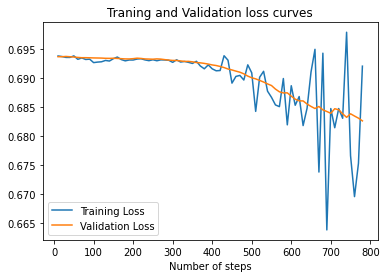

Finished Training


In [52]:
model = SiameseNetwork("absolute_substraction").cuda()
num_epochs = 20
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
threshold = 0.5
save_path = f'cifar_net.pt'
model = model.to(device)


TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_loss,threshold, device, save_path)

### 4.2.4 Evaluation

In [53]:
def eval(net, valid_loader):
    max_valid_acc = 0
    optimal_threshold = 0
    threshold_array = np.arange(0.0, 1.0, 0.02)
    for threshold in threshold_array:
        print(threshold)
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            for input1,input2, labels in tqdm(valid_loader):

                input1 = input1.to(device)
                input2 = input2.to(device)

                labels = labels.to(device)
                labels = labels.unsqueeze(1)
                labels = labels.float()

                outputs = net(input1,input2)
                preds = torch.gt(outputs, threshold).int()

                running_corrects += torch.sum(preds == labels.data)

            valid_acc = running_corrects / float(len(valid_loader.dataset))
            print("valid_acc: ", valid_acc)
            if(valid_acc > max_valid_acc):
                max_valid_acc = valid_acc
                optimal_threshold = threshold
    return max_valid_acc,optimal_threshold
                    

In [54]:
max_valid_acc,optimal_threshold = eval(model, valid_loader)

0.0



valid_acc:  tensor(0.5000, device='cuda:0')
0.02



valid_acc:  tensor(0.5000, device='cuda:0')
0.04



valid_acc:  tensor(0.5000, device='cuda:0')
0.06



valid_acc:  tensor(0.5000, device='cuda:0')
0.08



valid_acc:  tensor(0.5000, device='cuda:0')
0.1



valid_acc:  tensor(0.5000, device='cuda:0')
0.12



valid_acc:  tensor(0.5000, device='cuda:0')
0.14



valid_acc:  tensor(0.5000, device='cuda:0')
0.16



valid_acc:  tensor(0.5000, device='cuda:0')
0.18



valid_acc:  tensor(0.5000, device='cuda:0')
0.2



valid_acc:  tensor(0.5000, device='cuda:0')
0.22



valid_acc:  tensor(0.5000, device='cuda:0')
0.24



valid_acc:  tensor(0.5000, device='cuda:0')
0.26



valid_acc:  tensor(0.5000, device='cuda:0')
0.28



valid_acc:  tensor(0.5014, device='cuda:0')
0.3



valid_acc:  tensor(0.5000, device='cuda:0')
0.32



valid_acc:  tensor(0.5043, device='cuda:0')
0.34



valid_acc:  tensor(0.5014, device='cuda:0')
0.36



valid_acc:  tensor(0.5043, device='cuda:0')
0.38



valid_acc:  tensor(0.5129, device='cuda:0')
0.4



valid_acc:  tensor(0.5229, device='cuda:0')
0.42



valid_acc:  tensor(0.5343, device='cuda:0')
0.44



valid_acc:  tensor(0.5614, device='cuda:0')
0.46



valid_acc:  tensor(0.5700, device='cuda:0')
0.48



valid_acc:  tensor(0.5357, device='cuda:0')
0.5



valid_acc:  tensor(0.5514, device='cuda:0')
0.52



valid_acc:  tensor(0.5057, device='cuda:0')
0.54



valid_acc:  tensor(0.5000, device='cuda:0')
0.56



valid_acc:  tensor(0.5000, device='cuda:0')
0.58



valid_acc:  tensor(0.5000, device='cuda:0')
0.6



valid_acc:  tensor(0.5000, device='cuda:0')
0.62



valid_acc:  tensor(0.5000, device='cuda:0')
0.64



valid_acc:  tensor(0.5000, device='cuda:0')
0.66



valid_acc:  tensor(0.5000, device='cuda:0')
0.68



valid_acc:  tensor(0.5000, device='cuda:0')
0.7000000000000001



valid_acc:  tensor(0.5000, device='cuda:0')
0.72



valid_acc:  tensor(0.5000, device='cuda:0')
0.74



valid_acc:  tensor(0.5000, device='cuda:0')
0.76



valid_acc:  tensor(0.5000, device='cuda:0')
0.78



valid_acc:  tensor(0.5000, device='cuda:0')
0.8



valid_acc:  tensor(0.5000, device='cuda:0')
0.8200000000000001



valid_acc:  tensor(0.5000, device='cuda:0')
0.84



valid_acc:  tensor(0.5000, device='cuda:0')
0.86



valid_acc:  tensor(0.5000, device='cuda:0')
0.88



valid_acc:  tensor(0.5000, device='cuda:0')
0.9



valid_acc:  tensor(0.5000, device='cuda:0')
0.92



valid_acc:  tensor(0.5000, device='cuda:0')
0.9400000000000001



valid_acc:  tensor(0.5000, device='cuda:0')
0.96



valid_acc:  tensor(0.5000, device='cuda:0')
0.98



valid_acc:  tensor(0.5000, device='cuda:0')


In [55]:
print("validation accuracy: ",max_valid_acc," with threshold: ", optimal_threshold)

validation accuracy:  tensor(0.5700, device='cuda:0')  with threshold:  0.46


### Predict output

In [56]:
test_set = ImageDataset(PATH + 'test.csv', PATH + 'index.txt', PATH, transform=transform)
test_loader = DataLoader(test_set,
                         num_workers = 0,
                         batch_size=1,
                         shuffle=False)
test_df = pd.read_csv(PATH + 'test.csv')

In [57]:
predictions=[]
with torch.no_grad():
    for input1,input2, labels in tqdm(test_loader):

        input1 = input1.to(device)
        input2 = input2.to(device)

        outputs = model(input1,input2)
        preds = torch.gt(outputs, threshold).int()
        print(preds.cpu())
        predictions.append(preds.cpu())
        
test_df['target'] = predictions

test_df.to_csv("submission_QA8_Optimization_2.csv", index=False)#submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[1]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[0]], dtype=torch.int32)
tensor([[1

id1   id2                            target
0   4988  4973  [[tensor(0, dtype=torch.int32)]]
1   4958  4939  [[tensor(0, dtype=torch.int32)]]
2   4552  4891  [[tensor(1, dtype=torch.int32)]]
3   4509  4504  [[tensor(0, dtype=torch.int32)]]
4   4589  4587  [[tensor(0, dtype=torch.int32)]]
5   4635  4634  [[tensor(1, dtype=torch.int32)]]
6   4758  4751  [[tensor(0, dtype=torch.int32)]]
7   4544  4543  [[tensor(0, dtype=torch.int32)]]
8   4849  4887  [[tensor(0, dtype=torch.int32)]]
9   4929  4926  [[tensor(0, dtype=torch.int32)]]
10  4912  4918  [[tensor(1, dtype=torch.int32)]]
11  4705  4708  [[tensor(1, dtype=torch.int32)]]
12  4799  4864  [[tensor(1, dtype=torch.int32)]]
13  4763  4767  [[tensor(1, dtype=torch.int32)]]
14  4833  4839  [[tensor(0, dtype=torch.int32)]]
15  4533  4637  [[tensor(0, dtype=torch.int32)]]
16  4719  4712  [[tensor(0, dtype=torch.int32)]]
17  4969  4967  [[tensor(1, dtype=torch.int32)]]
18  4654  4921  [[tensor(1, dtype=torch.int32)]]
19  4575  4582  [[tensor(1, dtype=torch.int32)]]
20  4976  4975  [[tensor(1, dtype=torch.int32)]]
21  4915  4943  [[tensor(0, dtype=torch.int32)]]
22  4725  4985  [[tensor(0, dtype=torch.int32)]]
23  4967  4961  [[tensor(1, dtype=torch.int32)]]
24  4755  4754  [[tensor(1, dtype=torch.int32)]]
25  4825  4890  [[tensor(0, dtype=torch.int32)]]
26  4869  4725  [[tensor(0, dtype=torch.int32)]]
27  4892  4891  [[tensor(1, dtype=torch.int32)]]
28  4960  4951  [[tensor(0, dtype=torch.int32)]]
29  4508  4729  [[tensor(0, dtype=torch.int32)]]
30  4721  4723  [[tensor(1, dtype=torch.int32)]]
31  4956  4556  [[tensor(0, dtype=torch.int32)]]
32  4510  4502  [[tensor(0, dtype=torch.int32)]]
33  4515  4512  [[tensor(1, dtype=torch.int32)]]
34  4571  4578  [[tensor(1, dtype=torch.int32)]]
35  4897  4754  [[tensor(0, dtype=torch.int32)]]
36  4858  4853  [[tensor(0, dtype=torch.int32)]]
37  4842  4556  [[tensor(0, dtype=torch.int32)]]
38  4530  4523  [[tensor(0, dtype=torch.int32)]]
39  4582  4970  [[tensor(0, dtype=torch.int32)]]
40  4774  4565  [[tensor(0, dtype=torch.int32)]]
41  4562  4986  [[tensor(0, dtype=torch.int32)]]
42  4888  4882  [[tensor(0, dtype=torch.int32)]]
43  4651  4659  [[tensor(0, dtype=torch.int32)]]
44  4588  4583  [[tensor(1, dtype=torch.int32)]]
45  4769  4711  [[tensor(0, dtype=torch.int32)]]
46  4861  4870  [[tensor(1, dtype=torch.int32)]]
47  4510  4507  [[tensor(1, dtype=torch.int32)]]
48  4873  4871  [[tensor(0, dtype=torch.int32)]]
49  4604  4601  [[tensor(0, dtype=torch.int32)]]